# Preprocess

In [7]:
import h5py
import os
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import random

root_URL = r'/Users/wangyutao/Desktop/1901213567_王宇涛_作业3/'
train_URL = root_URL + r'Data/train/digitStruct.mat'
test_URL = root_URL + r'Data/test/digitStruct.mat'

In [2]:
# 查看文件结构
file = h5py.File(train_URL,'r')
data = file['digitStruct']
name = data['name']
bbox = data['bbox']

print(name.shape)
print(bbox.shape)

(33402, 1)
(33402, 1)


In [3]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inputFile):
        self.inputFile = h5py.File(inputFile, 'r')
        self.digitStructName = self.inputFile['digitStruct']['name']
        self.digitStructBbox = self.inputFile['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inputFile[self.digitStructName[n][0]]])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inputFile[attr[j].item()][0][0] for j in range(len(attr))]
        else:
            attr = [attr[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inputFile[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inputFile[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inputFile[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inputFile[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inputFile[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'Name' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['Bbox'] = figures
            result.append(item)
        return result

In [4]:
# 格式转换
train = DigitStructFile(train_URL)
train_data = train.getAllDigitStructure_ByDigit()

test = DigitStructFile(test_URL)
test_data = test.getAllDigitStructure_ByDigit()

In [5]:
# 查看元素
test_data[2019]

{'Name': '2020.png',
 'Bbox': [{'height': 22.0,
   'label': 3.0,
   'left': 201.0,
   'top': 79.0,
   'width': 11.0},
  {'height': 22.0, 'label': 6.0, 'left': 211.0, 'top': 78.0, 'width': 9.0},
  {'height': 22.0, 'label': 7.0, 'left': 219.0, 'top': 76.0, 'width': 9.0}]}

In [6]:
# 存入 pickle
pickle_file = 'svhn_raw.pkl'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_data': train_data,
    'test_data': test_data,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [7]:
# 读入 pkl
import pickle
pickle_file = 'svhn_raw.pkl'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_data = save['train_data']
    test_data = save['test_data']
    del save
    print('Train set', len(train_data))
    print('Test set', len(test_data))

Train set 33402
Test set 13068


In [10]:
class Dataset:
    """crop images and save them to numpy ndarray"""
    
    def __init__(self, digitStruct, folder):
        self.digitStruct = digitStruct
        self.folder = folder
        
    def setDataset(self):
        self.dataset = np.ndarray(shape=(len(self.digitStruct), 64, 64), dtype='float32')
        
        # 1 length + 5 labels, 0 represents none
        self.labels = np.ones(shape=(len(self.digitStruct), 6), dtype='int') * 10 
        
    def getDataset(self):
        
        self.setDataset()
        
        for i in range(len(self.digitStruct)):

            fin = os.path.join(self.folder, self.digitStruct[i]['Name'])
            im = Image.open(fin)
            
            boxes = self.digitStruct[i]['Bbox']
            
            if len(boxes) > 5:
                print(fin, "has more than 5 digits")
            else:
                self.labels[i,0] = len(boxes)
                self.labels[i,1:len(boxes)+1] = [int(j['label'] if j['label'] != 10 else 0) for j in boxes]
            
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            
            box = self.img_box(im, left, top, height, width)

            size = (64, 64)
            region = im.crop(box).resize(size)
            region = self.normalization(region)
#             print(region.shape)
            self.dataset[i,:,:] = region[:,:]
            
        print('dataset:',self.dataset.shape)
        print('labels:',self.labels.shape)
        return self.dataset, self.labels
        
    def img_box(self, im, left, top, height, width):

        im_left = min(left)
        im_top = min(top)
        im_height = max(top) + max(height) - im_top
        im_width = max(left) + max(width) - im_left

        im_top = im_top - im_height * 0.05 # a bit higher
        im_left = im_left - im_width * 0.05 # a bit wider
        im_bottom = min(im.size[1], im_top + im_height * 1.05)
        im_right = min(im.size[0], im_left + im_width * 1.05)

        return (im_left, im_top, im_right, im_bottom)


    def normalization(self, img):
#         im = self.rgb2gray(img) # RGB to greyscale
        im = img.convert('L')
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        return (im - mean) / std  
    
    def rgb2gray(self, img):
        return np.dot(np.array(img, dtype='float32'), [0.299, 0.587, 0.114])

In [11]:
train_dataset = Dataset(train_data, root_URL + 'Data/train')
train_images, train_labels = train_dataset.getDataset()

/Users/wangyutao/Desktop/1901213567_王宇涛_作业3/Data/train/29930.png has more than 5 digits
dataset: (33402, 64, 64)
labels: (33402, 6)


In [ ]:

num = 2021
plt.imshow(train_images[num,:,:])
print(train_labels[num])
# print(train_images[num,:,:])
print(np.max(train_images),np.min(train_images))


In [13]:
train_images = np.delete(train_images, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

print(train_images.shape)
print(train_labels.shape)

(33401, 64, 64)
(33401, 6)


In [14]:
test_dataset = Dataset(test_data, root_URL + 'Data/test')
test_images, test_labels = test_dataset.getDataset()

dataset: (13068, 64, 64)
labels: (13068, 6)


In [15]:
def disp_sample_dataset(images, labels):
    items = random.sample(range(images.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(labels[i][1:5])
        plt.imshow(images[i,:,:])

/Users/wangyutao/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


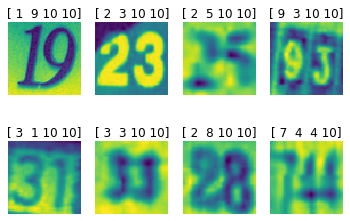

In [16]:
disp_sample_dataset(train_images, train_labels)

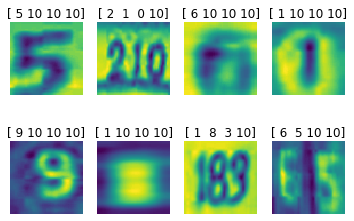

In [17]:
disp_sample_dataset(test_images, test_labels)

In [18]:
# 保存 dataset
pickle_file = 'svhn_dataset.pkl'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_images': train_images,
    'train_labels': train_labels,
    'test_images': test_images,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print("Done")
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Done


In [5]:
pickle_file = 'svhn_dataset.pkl'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_images = save['train_images']
    train_labels = save['train_labels']
    test_images = save['test_images']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Train set', train_images.shape, train_labels.shape)
    print('Test set', test_images.shape, test_labels.shape)

Train set (33401, 64, 64) (33401, 6)
Test set (13068, 64, 64) (13068, 6)


[ 4  2  4  4  1 10]
9.258291 -10.744409
1 5


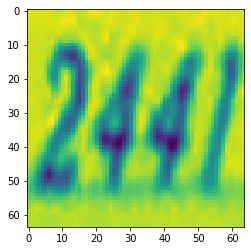

In [10]:
num = 2021
plt.imshow(train_images[num,:,:])
print(train_labels[num])
# print(train_images[num,:,:])
print(np.max(train_images),np.min(train_images))
print(np.min(train_labels[:,0]),np.max(train_labels[:,0]))